# Goal: Upload piece of artwork and get closest 2 or 3 art styles



In [320]:
Image(url="goals.png", width=900, height=500) 

In [321]:
Image(url="data.png", width=900, height=500) 

In [322]:
Image(url="/Users/juliafrench/Desktop/WikiArt/datalimts.png", width=900, height=500) 

In [323]:
Image(url="/Users/juliafrench/Desktop/WikiArt/otherlimits.png", width=900, height=500) 

In [1]:
import os
import datetime
import torch
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import torch.nn as nn
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, GlobalAvgPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, AdamW, Adamax
import collections
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from keras.models import Sequential
from keras.preprocessing import image
from collections import Counter
from IPython.display import Image 


/var/folders/6f/pl962ydj69n83g5xbrl18kgw0000gn/T/ipykernel_84090/3194174321.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [55]:

# Specify the directory containing your images
data_dir = '/Users/juliafrench/Desktop/WikiArt/archive'

# Create a dataset from the directory
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),  # Adjust as needed
    # batch_size=64,
    label_mode='categorical')

Found 57100 files belonging to 8 classes.


# Create Training and Validation Set

Generate images from original dataset

Over half of the images are in 8 of the styles

In [59]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    label_mode ='categorical',
    color_mode = 'rgb'
)

Found 57100 files belonging to 8 classes.
Using 45680 files for training.


55362 are in only 1 class

In [60]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    label_mode ='categorical',
    color_mode='rgb'
)

Found 57100 files belonging to 8 classes.
Using 11420 files for validation.


In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


# Model

In [78]:


model = Sequential()
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.25))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=8, activation="softmax"))

model.compile(optimizer=AdamW(beta_1=0.7), loss="categorical_crossentropy", metrics=["acc"])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.compile(optimizer=AdamW(beta_1=0.9), loss="categorical_crossentropy", metrics=["acc"])

In [85]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,119,578 (141.60 MB)

 Trainable params: 12,373,192 (47.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,746,386 (94.40 MB)

In [80]:
result = model.fit(
        train_ds,
        epochs=30,
        callbacks=[early_stop],
        validation_data=val_ds)

Epoch 1/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1533s 1s/step - acc: 0.2364 - loss: 4.7826 - val_acc: 0.2686 - val_loss: 1.8964
Epoch 2/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - acc: 0.3030 - loss: 1.8161 - val_acc: 0.3143 - val_loss: 1.7996
Epoch 3/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1553s 1s/step - acc: 0.3392 - loss: 1.7439 - val_acc: 0.3411 - val_loss: 1.7280
Epoch 4/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1538s 1s/step - acc: 0.3568 - loss: 1.7080 - val_acc: 0.3651 - val_loss: 1.6793
Epoch 5/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1550s 1s/step - acc: 0.3659 - loss: 1.6881 - val_acc: 0.3599 - val_loss: 1.7018
Epoch 6/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1522s 1s/step - acc: 0.3738 - loss: 1.6655 - val_acc: 0.3810 - val_loss: 1.6469
Epoch 7/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - acc: 0.3800 - loss: 1.6599 - val_acc: 0.3461 - val_loss: 1.7202
Epoch 8/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 1533s 1s/step - acc: 0.3946 - loss: 1.6198 - val_acc: 0.3943 - val_loss: 1.6293
Epoch 9/30
1428/1428 ━━━

In [81]:
loss,accuracy = model.evaluate(val_ds)
print("Validation Accuracy:\n", accuracy)
print("Validation Loss:\n", loss)

357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 236ms/step - acc: 0.4372 - loss: 1.5514
Validation Accuracy:
 0.4292469322681427
Validation Loss:
 1.5577555894851685


# Create Test Set

Random sample using another seed. using 10% of images.

In [293]:
test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=100,
    image_size=(64, 64),
    batch_size=32,
    label_mode ='categorical',
    color_mode='rgb',
    labels='inferred'
)

Found 57100 files belonging to 8 classes.
Using 5710 files for validation.


In [294]:
class_names = ['Art_Nouveua_Modern', 'Baroque', 'Expressionism', 'Impressionism', 'Post_Impressionism', 'Realism', 'Romanticism', 'Symbolism']

# Test Predictions

In [295]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [296]:
y_pred_labels = [class_names[i] for i in y_pred]
y_true_labels = [class_names[i] for i in y_true]

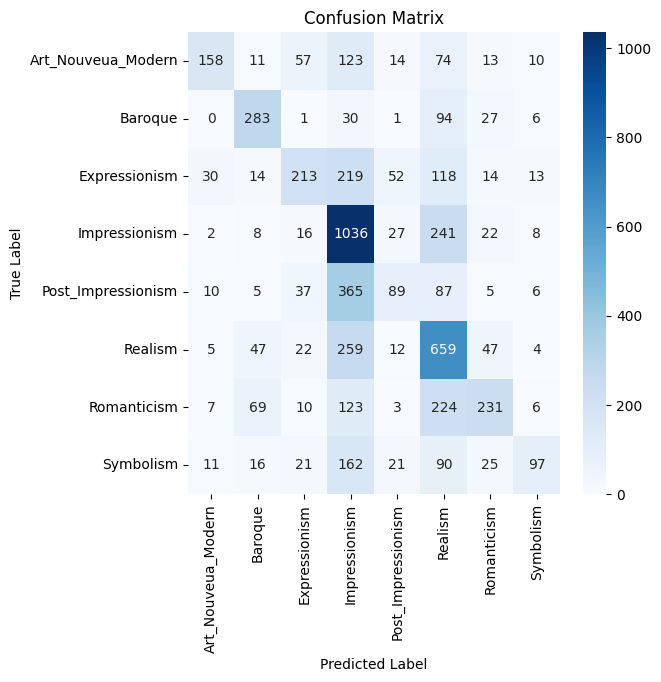

In [328]:
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
#cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Show Top 3 Predictions

In [168]:
y_true2 = []
y_pred2 = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true2.append(y)
  y_pred2.append(tf.argmax(model.predict(x),axis = 1)[-3:])
  
y_pred2 = tf.concat(y_pred2, axis=0)

y_true2 = tf.concat(y_true2, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 6, 0])>]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 6, 0])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 3, 5])>]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 6, 0])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 3, 5])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 2, 5])>]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 6, 0])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 3, 5])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 2, 5])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 7, 3])>]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 6, 0])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 3, 5])>, <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 2, 

In [304]:
word_index = {'Art_NM': 0, 'Baroque': 1, 'Expressionism': 2, 'Impressionism': 3, 'Post_Impressionism': 4, 'Realism': 5, 'Romanticism':6, 'Symbolism':7}

top_3 =y_pred2
numpy_array = top_3.numpy()

def group_into_tuples(lst, n=3):
    """Combines every n items in a list into a tuple."""
    return [tuple(lst[i:i+n]) for i in range(0, len(lst), n)]

result = group_into_tuples(numpy_array)


i = [60, 4, 22]
for x in i:
    for word, index in word_index.items():
        if index in result[x]:
            print(word)
    print("")



Expressionism
Impressionism
Realism

Baroque
Impressionism
Realism

Impressionism
Realism



# Test Multiple Styles 

### Baroque/Romanticism

In [281]:

# Specify the directory containing your images
data_dirMS = '/Users/juliafrench/Desktop/WikiArt/multiStyle/Baroque_Romanticism'
data_dirMS2 = '/Users/juliafrench/Desktop/WikiArt/multistyle2/Expressionism_PostImpressionism'


In [276]:
images = []
for img in os.listdir(data_dirMS):
    img = os.path.join(data_dirMS, img)
    img = image.load_img(img, target_size=(64, 64))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

In [277]:
y_predMS = []
for x in images:
  y_predMS.append(tf.argmax(model.predict(x),axis = 1))
  
y_predMS = tf.concat(y_predMS, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [292]:
top_2MS =y_predMS
numpy_array = top_2MS.numpy()

count_dict = Counter(numpy_array)

print(count_dict)

Counter({1: 18, 5: 3, 6: 1})


### Expressionism/Post-Impressionism

In [287]:
images2 = []
for img in os.listdir(data_dirMS2):
    img = os.path.join(data_dirMS2, img)
    img = image.load_img(img, target_size=(64, 64))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images2.append(img)

In [288]:
y_predMS2 = []
for x in images2:
  y_predMS2.append(tf.argmax(model.predict(x),axis = 1))
  
y_predMS2 = tf.concat(y_predMS2, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [291]:
top_2MS2 =y_predMS2
numpy_array2 = top_2MS2.numpy()

count_dict2 = Counter(numpy_array2)

print(count_dict2)

Counter({3: 12, 4: 7, 5: 5, 2: 2, 0: 1})


In [319]:
Image(url="/Users/juliafrench/Desktop/WikiArt/future.png", width=900, height=500) 